# Imports

In [74]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =  (8,6)
#plt.rcParams["figure.figsize"] =  plt.rcParamsDefault["figure.figsize"]
import numpy as np
import pandas as pd
import os
import inspect
from scipy.optimize import curve_fit
from scipy.special import ellipk as K1
from scipy.special import ellipe as K2 #Complete elliptic integral of the first kind
from scipy.stats import chi2

In [75]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "ising_data_final")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
ls_files = [file for file in abs_files if not file.find('LS')==-1]
datas= []
corrs= []
lattice_states = []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)
for file in ls_files:
    lattice_state = pd.read_csv(file, sep=",", skiprows=[0,1,2], header=None)
    lattice_states.append(lattice_state)


# Analytic Calculations

In [76]:
def safe_log10(x, order: int = -10):
    eps = 10**order
    result = np.where(x > eps, x, order)
    result = np.where(result > 0, np.log10(result), order) #Avoid log(0) 
    return result

def safe_log(x, order: int = -10):
    x_log10 = safe_log10(x, order)
    return x_log10 * np.log(10) #Convert to natural log

T_c_analytic = 2/safe_log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model
ln_T_c_analytic = safe_log(T_c_analytic)

def get_E_mean_analytic(T):
    """Calculate the mean energy for the 2D Ising model at temperature T."""
    assert (T >= 0).all(), "Temperature is negative"
    sinh_T = np.sinh(2/T)
    cosh_T = np.cosh(2/T)
    tanh_T = np.tanh(2/T)
    #kappa = 2*sinh_T/cosh_T**2
    kappa = 2*tanh_T/cosh_T #Numerically more stable?
    ellip_int = K1(kappa)
    return -2*tanh_T-(sinh_T**2-1)/(sinh_T*cosh_T)*(2/np.pi*ellip_int-1)

def get_M_abs_analytic(T, T_c = T_c_analytic, B=None): #Absolute value because of spontaneous symmetry breaking
    assert (T >= 0).all(), "Temperature is negative"
    if B is not None:
        assert (B == 0).all(), "Expression only valid for B = 0"
    M_abs_inner = 1-np.sinh(2/T)**-4
    M_abs = np.where(T>=T_c,0,np.sign(M_abs_inner)*np.abs(M_abs_inner)**(1/8)) #Note continuity at T = T_c
    return M_abs

def get_cV_analytic(T):
    assert (T >= 0).all(), "Temperature is negative"
    b = 2/T #Thermodynamic beta up to a multiplicative constant
    sinh_b = np.sinh(b)
    cosh_b = np.cosh(b)
    tanh_b = np.tanh(b)
    kappa_b = 2*tanh_b/cosh_b #Numerically more stable?
    K1_int = K1(kappa_b)
    K2_int = K2(kappa_b)
    K1_prime =  (K2_int/(1-kappa_b**2)-K1_int)/kappa_b 
    zero_term = sinh_b**-2
    first_term = -(sinh_b**-2+2*cosh_b**-2)*(2/np.pi)*K1_int
    second_term = 4/np.pi*(sinh_b**2-1)**2/(sinh_b*cosh_b**4)*K1_prime
    cV_analytic = -b**2/2 * (zero_term + first_term + second_term)
    return cV_analytic

def get_chi_analytic(T): #Need partial derivative of M with respect to B
    assert (T >= 0).all(), "Temperature is negative"
    return 0

# Fitting

In [77]:
#Models for fitting
def power_law_fit(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( np.abs(t)** crit_exp)

def power_law_fit_neg(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( np.abs(t)** -crit_exp)

def power_law_exp_decay_fit(d, R_0, eta, d_c, xi):
   return np.where(d>d_c,R_0 * np.exp(d/-xi),R_0*d_c**eta*d**(-eta)* np.exp(d_c/-xi)) 

def linearized_power_law_fit(ln_X, k, X_c, crit_exp):
    return  safe_log(k) + crit_exp * (safe_log(np.exp(ln_X)-X_c)-safe_log(X_c))

#Assumes B = 0
def M_abs_analytic_fit(T, T_c): #Absolute value because of spontaneous symmetry breaking
    assert (T >= 0).all(), "Temperature is negative"
    M_abs_inner = 1-np.sinh(2/T*T_c/T_c_analytic)**-4
    M_abs = np.where(T>=T_c,0,np.sign(M_abs_inner)*np.abs(M_abs_inner)**(1/8)) #Note continuity at T = T_c
    return M_abs

#Returns bounds as formatted for curve_fit
#[(L1,U1),(L2,U2),...(LN,UN)] to ([L1,L2,...,LN],[U1,U2,...,UN])
def to_tuple(bounds: list):
  lower = [b[0] for b in bounds]
  upper = [b[1] for b in bounds]
  return (lower,upper)



In [78]:
def fit(fitting_model, X, X_c, Y_mean, Y_std, expected_crit_exp = 1.0,  from_above = True, print_summary = True, maxfev=10000):
    assert fitting_model is not None, "No fitting model provided"
    assert (Y_std != np.zeros_like(Y_std)).all(), "Y_std is identically zero"
    T_c_bounds = (2, 3) #Bounds for T_c
    T_c_initial = np.average(T_c_bounds) #Initial value for T_c
    if fitting_model is power_law_fit or fitting_model is power_law_fit_neg:
        bounds = to_tuple([(0, np.inf), T_c_bounds, (0, np.inf)]) #Bounds for k, T_c, crit_exp  
        param_ests = [1, T_c_initial, 1] #Initial values for k, T_C, crit_exp
    elif fitting_model is power_law_exp_decay_fit:
        d_max = len(X)
        R_typical = np.mean(np.abs(Y_mean))
        print(f"R_typical: {R_typical}")
        bounds = to_tuple([(0, np.inf), (0, 2*expected_crit_exp), (0, d_max+1), (0, d_max+1)])  #Bounds for R_0, eta, d_c, xi
        param_ests = [R_typical, expected_crit_exp/2, 5, 1] #Initial values for R_0, eta, d_c, xi
    elif fitting_model is M_abs_analytic_fit:
        bounds = to_tuple([T_c_bounds]) #Bounds for T_c
        param_ests = [T_c_initial] #Initial value for T_c
    else:
        raise ValueError("Unsupported fitting model provided")
    
    if X_c is not None and from_above is not None:
        if from_above: #Only use X data greater than or equal to X_c
            X_filt = X[X >= X_c]
            Y_mean_filt = Y_mean[X >= X_c]
            Y_std_filt = Y_std[X >= X_c]             
        else: #Only use X data less than or equal to X_c
            X_filt = X[X <= X_c]
            Y_mean_filt = Y_mean[X <= X_c]
            Y_std_filt = Y_std[X <= X_c]
    else:
        X_filt = X
        Y_mean_filt = Y_mean
        Y_std_filt = Y_std

    if not np.isfinite(X_filt).all():
        raise ValueError("X_filt contains infinity values")
    if not np.isfinite(Y_mean_filt).all():
        raise ValueError("Y_mean_filt contains infinity values")
    if not np.isfinite(Y_std_filt).all():
        raise ValueError("Y_std_filt contains infinity values")
    if np.isnan(X_filt).any():
        raise ValueError("X_filt contains NaN values")
    if np.isnan(Y_mean_filt).any():
        raise ValueError("Y_mean_filt contains NaN values")
    if np.isnan(Y_std_filt).any():
        raise ValueError("Y_std_filt contains NaN values")

    popt, pcov = curve_fit(fitting_model, X_filt, Y_mean_filt, sigma=Y_std_filt, p0=param_ests,bounds=bounds, maxfev=maxfev)
    Y_mean_filt_fit = fitting_model(X_filt,*popt)      
    Y_mean_filt_res = Y_mean_filt - Y_mean_filt_fit
    Y_mean_filt_norm_res = Y_mean_filt_res/Y_std_filt
    N_filt = len(Y_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(Y_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    
    pte = chi2.sf(chi_squared, degrees_of_freedom) #p-value for the fit
    param_errs = np.sqrt(np.diag(pcov))

    param_names = list(inspect.signature(fitting_model).parameters.keys())[1:]    
    param_text = [f"{name} = {param:.2f} ± {err:.2f}" for name, param, err in zip(param_names, popt, param_errs)]
    param_text = "\n".join(param_text)
    chi_squared_text = r'$\chi^2_{\nu} = $'+f"{reduced_chi_squared:.2f}"
    pte_text = r'$p = $'+f"{pte:.2f}"

    if print_summary:
        print(f"Fitting model: {fitting_model.__name__}")
        print(f"Fitting parameters:\n{param_text}")
        print(f"Expected critical exponent: {expected_crit_exp:.2f}")
        print(f"Covariance matrix:\n{pcov}")        
        print(f"Reduced chi squared: {reduced_chi_squared:.2f}")  
        print(f"Probability to exceed: {pte:.2f}")  

    legend_text = "Fit"+"\n"    
    legend_text += f"{chi_squared_text}, {pte_text}"

    return popt, pcov, X_filt, Y_mean_filt_norm_res, legend_text
        
       

## Depracated due to fit

In [79]:
'''
def T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):
    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    
    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    if from_above: #Approach critical temperature from above
        T_filt = T[T >= T_c_analytic]
        X_mean_filt = X_mean[T >= T_c_analytic]
        X_std_filt = X_std[T >= T_c_analytic]                
    else: #Approach critical temperature from below
        T_filt = T[T <= T_c_analytic]
        X_mean_filt = X_mean[T <= T_c_analytic]
        X_std_filt = X_std[T <= T_c_analytic] 

    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)

    X_mean_filt_fit = power_law_fit(T_filt,*popt)      
    X_mean_filt_res = X_mean_filt - X_mean_filt_fit
    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt
    N_filt = len(X_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(X_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    if print_summary:
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")
    return popt, pcov, X_mean_filt_norm_res   
'''

'\ndef T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):\n    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    \n    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp\n    if from_above: #Approach critical temperature from above\n        T_filt = T[T >= T_c_analytic]\n        X_mean_filt = X_mean[T >= T_c_analytic]\n        X_std_filt = X_std[T >= T_c_analytic]                \n    else: #Approach critical temperature from below\n        T_filt = T[T <= T_c_analytic]\n        X_mean_filt = X_mean[T <= T_c_analytic]\n        X_std_filt = X_std[T <= T_c_analytic] \n\n    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)\n\n    X_mean_filt_fit = power_law_fit(T_filt,*popt)      \n    X_mean_filt_res = X_mean_filt - X_mean_filt_fit\n    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt\n    N_filt = len(X_me

# Single CSV Calculations and Plotting

## Single CSV Calculations

In [80]:
#Settings for the analysis
selected_trial = -1 #Particular trial to analyze (0-indexed)

#Extract data from pandas DataFrame
data_selected_trial = datas[selected_trial]
corr_selected_trial = corrs[selected_trial]
if len(lattice_states) != 0:
    lattice_state = lattice_states[selected_trial].to_numpy()
else:
    lattice_state = None
T, E_mean, E_std, M_mean, M_std= data_selected_trial.T.to_numpy()
corr_data = corr_selected_trial.T.to_numpy()
T_corr = corr_data[0]
assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
R_data = corr_data[1:]
R_mean_matrix, R_std_matrix = np.array([R_data[i] for i in range(0,len(R_data),2)]), np.array([R_data[i] for i in range(1,len(R_data),2)])

cV = np.square(E_std)/np.square(T) #In units where k_B = 1
chi = np.square(M_std)/T #In units where k_B = 1
#cV_mean will need to come from combined best estimate: average of cV over CSVs (weighted by cV itself because this is the best estimate for the error of each cV?)
#cV_std will need to come from the standard error of standard deviation
#Same for chi_mean, chi_std

N = len(T) #Number of points in the data
def get_ln_std(X_mean, X_std, use_asymetric_error=True):
    if use_asymetric_error: #Asymmetric error handling
        ln_X_std_lower = np.abs(safe_log(X_mean-X_std)) 
        ln_X_std_upper = np.abs(safe_log(X_mean+X_std))
        ln_X_std = [ln_X_std_lower, ln_X_std_upper] 
    else:
        ln_X_std = X_std / X_mean  # Propagated error (necessarily symmetric)
    return ln_X_std

In [81]:
if len(lattice_states) > 0:
    lattice_indices = [0,2,1] #T<<T_c, T~T_c, T_c<<T
    lattice_states_for_plot = [lattice_states[i] for i in lattice_indices]
    fig, axs = plt.subplots(1,len(lattice_states_for_plot))
    lattice_labels = [r"$T \ll T_c$", r"$T \approx T_c$", r"$T \gg T_c$"]
    if len(lattice_states_for_plot) == 1:
        axs = [axs] #Make sure axs is always a list of axes
    for ax, lattice_state, label in zip(axs, lattice_states_for_plot, lattice_labels):
        N_lattice = lattice_state.shape[0]
        print(N_lattice)
        ax.imshow(lattice_state, cmap='RdBu', interpolation='none', vmin=-1, vmax=1)
        ax.set_title(label)

        # Major ticks
        ax.set_xticks(np.arange(0, N_lattice, 1),)
        ax.set_yticks(np.arange(0, N_lattice, 1))

        # Labels for major ticks
        #ax.set_xticklabels(np.arange(1, 11, 1))
        #ax.set_yticklabels(np.arange(1, 11, 1))

        # Minor ticks
        ax.set_xticks(np.arange(-.5, N_lattice, 1), minor=True)
        ax.set_yticks(np.arange(-.5, N_lattice, 1), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

        # Remove minor ticks
        ax.tick_params(which='minor', bottom=False, left=False)

        #Remove major ticks
        ax.tick_params(which='major', bottom=False, left=False)
        #Remove tick labels
        ax.tick_params(labelbottom=False, labelleft=False)
        #ax.set_title(f"Trial {selected_trial+1}")

In [82]:
def create_plot(X, X_symbol=r"?", X_name=r"???", X_c = None, X_c_symbol = None, Y_mean=None, Y_std=None, Y_symbol=r"?", Y_name=r"???", get_Y_analytic=None, log_plot = True, fitting_model=None, expected_crit_exp = 1.0, from_above=True, print_summary = True):   
    #Error handling
    assert Y_mean is not None, "No vertical data given"
    if Y_std is None: #No error is given
        Y_std = np.zeros_like(Y_mean)
        with_errorbar = False
    else: #Check if error is identically 0
        with_errorbar = not (Y_std == np.zeros_like(Y_std)).all() 
    if not with_errorbar:
        print("*Proceeding assuming no error (unphysical)")
    if X_c_symbol is None:
        X_c_symbol = X_symbol     

    X_fit = None
    if fitting_model is not None: #Work in progress: need to be careful with signs        
        popt, pcov, X_fit, Y_mean_norm_res_fit, fit_legend_text=  fit(fitting_model, X, X_c, Y_mean, Y_std, expected_crit_exp=expected_crit_exp, from_above=from_above, print_summary=print_summary) #Fit the data
    
    X_min, X_max = np.min(X), np.max(X)   
    
    if get_Y_analytic is not None:    
        X_analytic = np.linspace(X_min, X_max, 1000)
        Y_mean_analytic = get_Y_analytic(X_analytic) #T_analytic is of high spatial frequency to produce a smooth curve
    else:
        X_analytic = None
        Y_mean_analytic = None

    if fitting_model is not None:
        X_fit_min, X_fit_max = np.min(X_fit), np.max(X_fit)
        X_fit_smooth = np.linspace(X_fit_min, X_fit_max, 1000) #X_fit_smooth is of high spatial frequency to produce a smooth curve
        Y_mean_fit = fitting_model(X_fit_smooth, *popt)
    else:
        X_fit_smooth = None
        Y_mean_fit = None

    if log_plot: #Calculations specific and plotting labels specific to using log plot
        ln_X_fit = safe_log(X_fit)
        ln_X = safe_log(X)
        if X_c is not None:
            ln_X_c = safe_log(X_c)
        else:
            ln_X_c = None
        ln_Y_mean = safe_log(Y_mean)
        ln_Y_std = get_ln_std(Y_mean, Y_std)

        if get_Y_analytic is not None or fitting_model is not None: #If present, get high density ln_X called ln_X_smooth                       
            ln_X_smooth = np.linspace(np.log(X_min), np.log(X_max), 1000)
        else:
            ln_X_smooth = None

        if get_Y_analytic is not None:
            ln_X_analytic = np.linspace(safe_log(X_min), safe_log(X_max), 1000)
            ln_Y_mean_analytic = safe_log(get_Y_analytic(np.exp(ln_X_smooth)))
        else:
            ln_X_analytic = None
            ln_Y_mean_analytic = None

        if fitting_model is not None:
            ln_X_fit_smooth = np.linspace(safe_log(X_fit_min), safe_log(X_fit_max), 1000)
            ln_Y_mean_fit = safe_log(fitting_model(np.exp(ln_X_smooth), *popt))
        else:
            ln_X_fit_smooth = None
            ln_Y_mean_fit = None            
            
        using = [ln_X,ln_X_analytic, ln_X_fit_smooth,ln_X_c, ln_Y_mean, ln_Y_std, ln_Y_mean_analytic, ln_Y_mean_fit, ln_X_fit]
        X_label = f'$ln({X_symbol})$'
        Y_label = f'$ln({Y_symbol})$'
    else: #Calculations specific and plotting labels specific to non log plots     
        using = [X,X_analytic, X_fit_smooth,X_c,Y_mean, Y_std, Y_mean_analytic, Y_mean_fit, X_fit] #No analytic curve for non-power-law fits
        X_label = f'${X_symbol}$'    
        Y_label = f'${Y_symbol}$'    
    fit_ax = None
    if get_Y_analytic is not None: #Calculations and plotting specific to having an analytic model
        #Residual calculations
        Y_mean_res_analytic = Y_mean - get_Y_analytic(X)
        Y_std_res_analytic = Y_std
        Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std
        Y_std_norm_res_analytic = 1 #Always 1 since X_std_norm_res_analytic = X_std_res_analytic / X_std = 1

        #Goodness of fit to analytic model
        degrees_of_freedom_analytic = N #Relies on global variable in cell above
        chi_squared_analytic= np.sum(np.square(Y_mean_norm_res_analytic)) 
        reduced_chi_squared_analytic = chi_squared_analytic / degrees_of_freedom_analytic     
        print(f"Reduced chi squared (analytic): {reduced_chi_squared_analytic}")

        #Plotting specific to having an analytic model
        if fitting_model is not None:
            fig, axs = plt.subplots(3,1, constrained_layout=True, sharex=True, height_ratios=[2, 1, 1])  
            fit_ax = axs [2]          
        else:
            fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
        ax, res_ax = axs[0], axs[1]                
        res_ax.errorbar(using[0], Y_mean_norm_res_analytic, yerr=Y_std_norm_res_analytic, fmt='o', color='blue', label='Residuals (analytic)')
        if X_c is not None:
            res_ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')      
        ax.plot(using[1], using[6], color='orange', label='Analytic') 
        if fitting_model is None:           
            res_ax.set_xlabel(X_label)
        res_ax.set_ylabel('Normalized Residual (analytic)')
        res_ax.axhline(0, color='orange', linestyle='--')      
    else: #Plotting specific to not having an analytic model
        if fitting_model is not None:
            fig, axs = plt.subplots(2,1, constrained_layout = True, sharex=True, height_ratios=[2, 1])
            fit_ax = axs[1]
            ax = axs[0]
        else:
            fig, ax = plt.subplots(1,1)
            ax.set_xlabel(X_label)

    if fitting_model is not None:
        ax.plot(using[2], using[7], color='green', label=fit_legend_text) #Plot the fit
        Y_std_norm_res_fit = 1       
        fit_ax.set_ylabel('Normalized Residual (fit)')
        fit_ax.errorbar(using[8], Y_mean_norm_res_fit, yerr= Y_std_norm_res_fit, fmt='o', color='blue', label='Residuals (fit)')
        fit_ax.axhline(0, color='green', linestyle='--')
        fit_ax.set_xlabel(X_label)
        if X_c is not None:
            fit_ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)') 
    
    #Plotting common to all variants    
    if with_errorbar:
        ax.errorbar(x=using[0], y=using[4], yerr=using[5], fmt='o', color='blue', label='Simulated')
    else:        
        ax.errorbar(x=using[0], y=using[4], fmt='o', yerr=None, color='blue', label='Simulated')
    ax.set_ylabel(Y_label)
    if X_c is not None:
        ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')        
    ax.legend()
    ax.set_title(f'{Y_name} vs {X_name}')
    plt.show()

In [83]:
def create_T_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_fit, expected_crit_exp = 1.0, from_above=True, T_filt=None):   
   if T_filt is None:
      T_filt = T
   create_plot(X=T_filt, X_symbol=r"k_B T / J", X_name=r"Temperature", X_c = T_c_analytic, X_c_symbol="T", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)

In [84]:
def create_d_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_exp_decay_fit, expected_crit_exp = 1/4, from_above=True, print_summary = True):   
   create_plot(X=np.array([i for i in range(1,len(mean)+1)]), X_symbol=r"x", X_name=r"Normalized Separation Distance", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above, print_summary=print_summary)
def d_fit(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_exp_decay_fit, expected_crit_exp = 1/4, print_summary = True):
   return fit(fitting_model=fitting_model, X=np.array([i for i in range(1,len(mean)+1)]), X_c = None, Y_mean=mean, Y_std=std, expected_crit_exp=expected_crit_exp, print_summary=print_summary)

## Single CSV Plots

Reduced chi squared (analytic): 0.8485936182281804


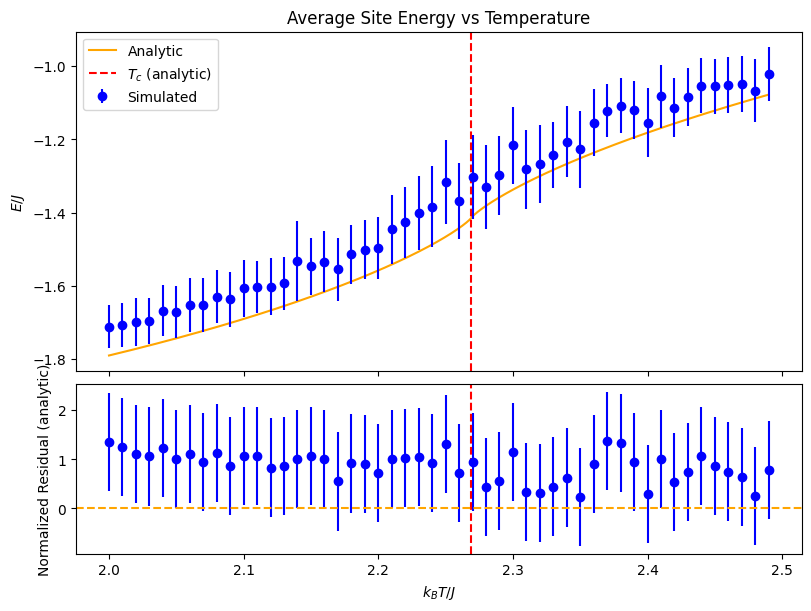

In [85]:
create_T_plot(E_mean, E_std, symbol = 'E/J', name = 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic, fitting_model=None)

In [ ]:
create_T_plot(mean=np.abs(M_mean), std=M_std, symbol='|M|', name='Average Spin', log_plot=True, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, from_above = False)

Fitting model: M_abs_analytic_fit
Fitting parameters:
T_c = 2.25 ± 0.01
Expected critical exponent: 0.12
Covariance matrix:
[[7.68974167e-05]]
Reduced chi squared: 0.90
Probability to exceed: 0.62
Reduced chi squared (analytic): 1.0929919981631955


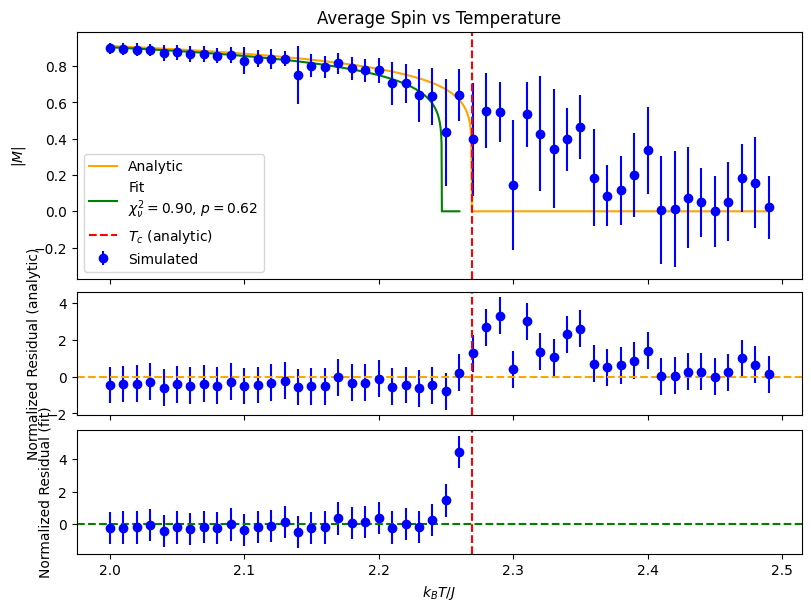

In [ ]:
create_T_plot(np.abs(M_mean), M_std, symbol='|M|', name='Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, fitting_model=M_abs_analytic_fit, from_above = False)

*Proceeding assuming no error (unphysical)
Reduced chi squared (analytic): inf


C:\Users\17757\AppData\Local\Temp\ipykernel_45384\965011044.py:76: RuntimeWarning: divide by zero encountered in divide
  Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std


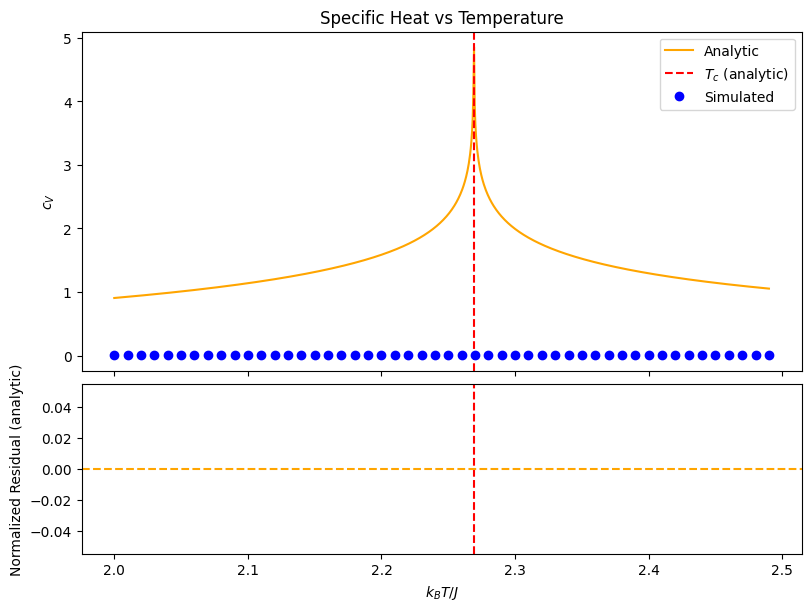

In [ ]:
create_T_plot(cV, symbol='c_V', name='Specific Heat', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic, fitting_model=None) #zeros_like forces std to default which is then propagated for ln

# Autocorrelation Single

In [ ]:
show_T_scan_at_fixed_d = False
if show_T_scan_at_fixed_d:
    for d, (R_mean, R_std) in enumerate(zip(R_mean_matrix, R_std_matrix), start=1):
        create_T_plot(mean=R_mean, std=R_std, symbol=f'R({d})', name=f'Autocorrelation Function (d = ${d}$)', log_plot = False, expected_crit_exp=0.0, fitting_model=None) #zeros_like forces std to default which is then propagated for ln

In [ ]:
def get_xi_vs_T(T,R_mean_matrix, R_std_matrix, T_range = 0.05, plot_d_scan = False): 
    T_selected = []
    xi_mean = []
    xi_std = []
    for (T_current, R_mean, R_std) in zip(T, R_mean_matrix.T, R_std_matrix.T):
        R_mean_abs = np.abs(R_mean) #Take absolute value of R_mean to avoid negative values
        if np.abs(T_current - T_c_analytic) < T_range: #Only consider T values close to T_c
            if plot_d_scan:
                create_d_plot(mean=R_mean_abs, std=R_std, symbol='|R|', name=f"Autocorrelation Function (T = {T_current:.2f})", get_analytic=None, log_plot = False, fitting_model=power_law_exp_decay_fit, expected_crit_exp = 1/4, print_summary = True)
            popt, pcov, X_filt, Y_mean_filt_norm_res, legend_text  = d_fit(R_mean, std=R_std, symbol='|R|', name=f"Autocorrelation Function (T = {T_current:.2f})", get_analytic=None, log_plot = True, fitting_model=power_law_exp_decay_fit, expected_crit_exp = 1/4, print_summary = False)
            T_selected.append(T_current)
            xi_mean.append(popt[3])
            xi_std.append(np.sqrt(np.diag(pcov))[3])
    T_selected = np.array(T_selected)
    xi_mean = np.array(xi_mean)
    xi_std = np.array(xi_std)
    return T_selected, xi_mean, xi_std

R_typical: 0.0016424002297007211
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 683648.83
eta = 0.00 ± 0.38
d_c = 14.00 ± 10.21
xi = 6.46 ± 188654308.52
Expected critical exponent: 0.25
Covariance matrix:
[[ 4.67375726e+11 -8.42419298e+04 -5.72173925e+06 -1.28973298e+14]
 [-8.42419298e+04  1.44700261e-01  1.67554482e+00  2.32467347e+07]
 [-5.72173925e+06  1.67554482e+00  1.04299893e+02  1.57892579e+09]
 [-1.28973298e+14  2.32467347e+07  1.57892579e+09  3.55904481e+16]]
Reduced chi squared: 0.58
Probability to exceed: 0.84


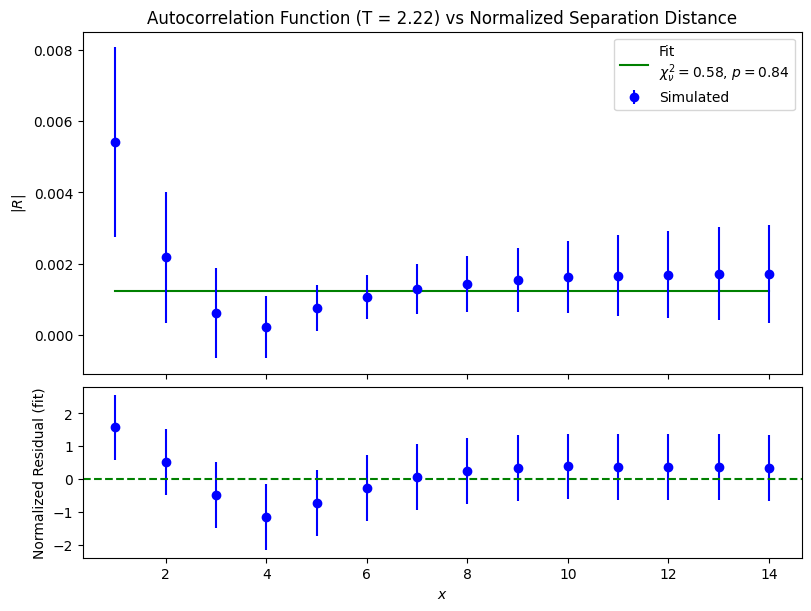

R_typical: 0.0016424002297007211
R_typical: 0.002274235347321236
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 1325823.30
eta = 0.00 ± 0.48
d_c = 14.00 ± 13.29
xi = 8.57 ± 878485508.37
Expected critical exponent: 0.25
Covariance matrix:
[[ 1.75780742e+12 -1.77212069e+05  1.04789320e+07 -1.16471655e+15]
 [-1.77212069e+05  2.32170651e-01  3.43326759e-01  1.17420047e+08]
 [ 1.04789320e+07  3.43326759e-01  1.76695324e+02 -6.94330071e+09]
 [-1.16471655e+15  1.17420047e+08 -6.94330071e+09  7.71736788e+17]]
Reduced chi squared: 0.80
Probability to exceed: 0.63


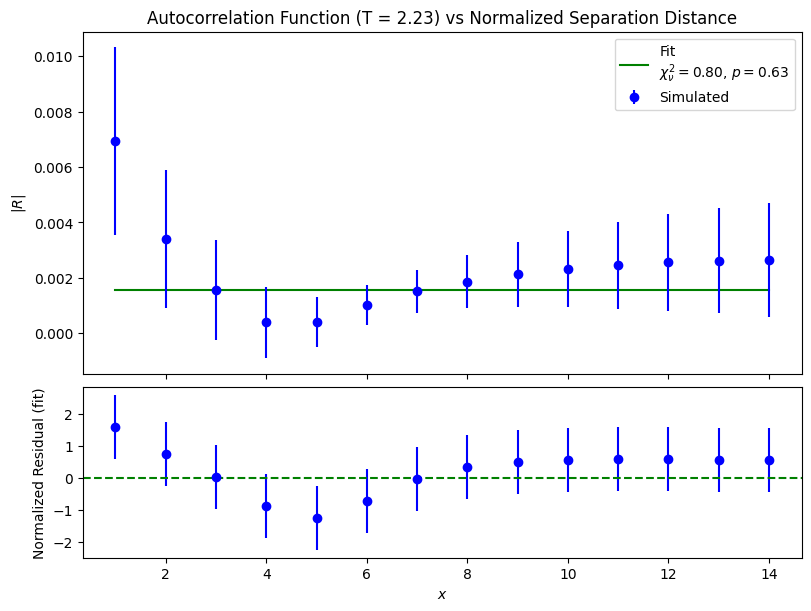

R_typical: 0.002274235347321236
R_typical: 0.002159284209332914
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 3184240.10
eta = 0.00 ± 0.51
d_c = 14.00 ± 8.33
xi = 6.33 ± 648246352.95
Expected critical exponent: 0.25
Covariance matrix:
[[ 1.01393850e+13 -9.28014866e+05  1.65372997e+07 -2.06417203e+15]
 [-9.28014866e+05  2.58840893e-01 -6.66269917e-01  1.88924903e+08]
 [ 1.65372997e+07 -6.66269917e-01  6.93937457e+01 -3.36665699e+09]
 [-2.06417203e+15  1.88924903e+08 -3.36665699e+09  4.20223334e+17]]
Reduced chi squared: 0.77
Probability to exceed: 0.66


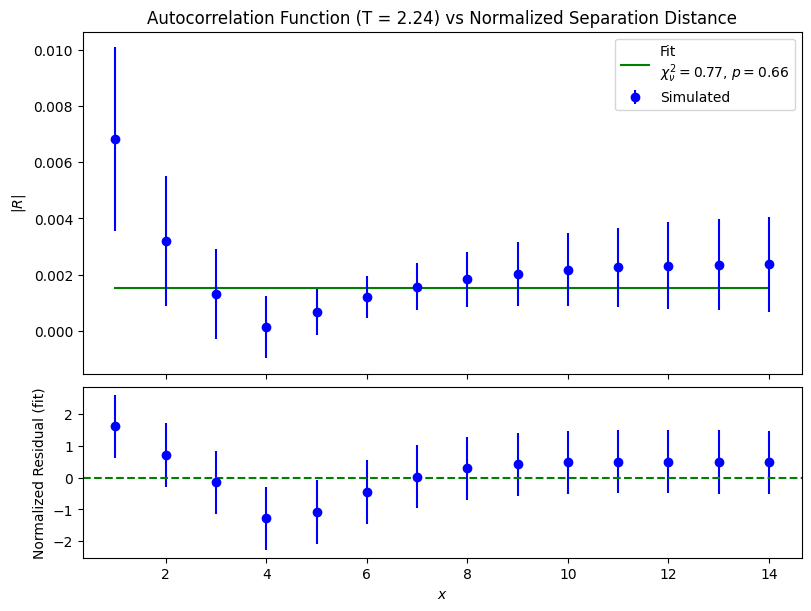

R_typical: 0.002159284209332914
R_typical: 0.003271059925615679
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 431640.91
eta = 0.00 ± 0.55
d_c = 14.00 ± 22.95
xi = 13.96 ± 1084143709.81
Expected critical exponent: 0.25
Covariance matrix:
[[ 1.86313874e+11  1.78602824e+04 -4.42174320e+06 -4.67960775e+14]
 [ 1.78602824e+04  3.05003024e-01  2.84499279e+00 -4.48593089e+07]
 [-4.42174320e+06  2.84499279e+00  5.26822112e+02  1.11060030e+10]
 [-4.67960775e+14 -4.48593089e+07  1.11060030e+10  1.17536758e+18]]
Reduced chi squared: 1.17
Probability to exceed: 0.30


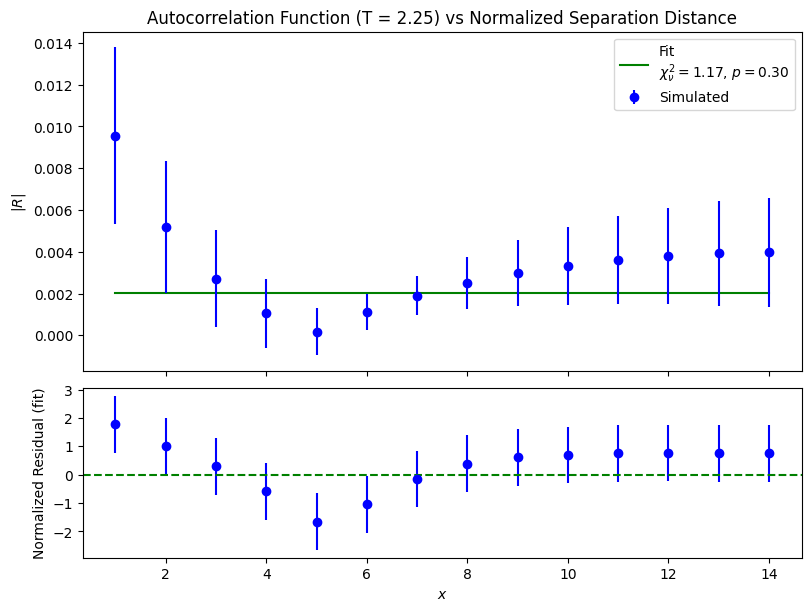

R_typical: 0.003271059925615679
R_typical: 0.002005741054027707
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 1965289.35
eta = 0.00 ± 0.40
d_c = 14.00 ± 17.59
xi = 7.46 ± 771730609.53
Expected critical exponent: 0.25
Covariance matrix:
[[ 3.86236223e+12  3.72313272e+05  3.22983851e+07 -1.51667395e+15]
 [ 3.72313272e+05  1.58672459e-01  3.81444587e+00 -1.46200125e+08]
 [ 3.22983851e+07  3.81444587e+00  3.09311707e+02 -1.26829428e+10]
 [-1.51667395e+15 -1.46200125e+08 -1.26829428e+10  5.95568134e+17]]
Reduced chi squared: 0.65
Probability to exceed: 0.77


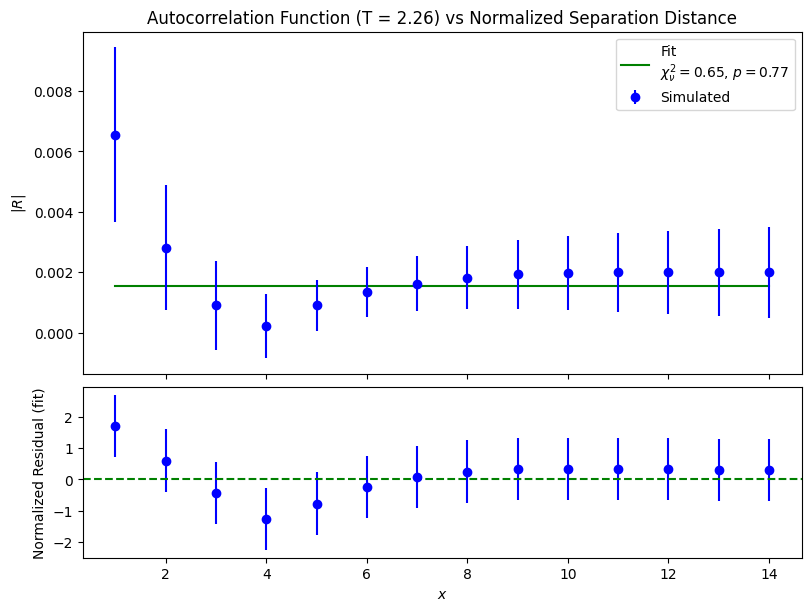

R_typical: 0.002005741054027707
R_typical: 0.0033540927687732845
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 177065.46
eta = 0.00 ± 0.60
d_c = 14.00 ± 22.12
xi = 13.97 ± 432372276.72
Expected critical exponent: 0.25
Covariance matrix:
[[ 3.13521754e+10 -3.83783359e+04 -3.27254916e+05 -7.65581939e+13]
 [-3.83783359e+04  3.62603665e-01  3.67450924e+00  9.37152222e+07]
 [-3.27254916e+05  3.67450924e+00  4.89098737e+02  7.99117090e+08]
 [-7.65581939e+13  9.37152222e+07  7.99117090e+08  1.86945786e+17]]
Reduced chi squared: 1.30
Probability to exceed: 0.22


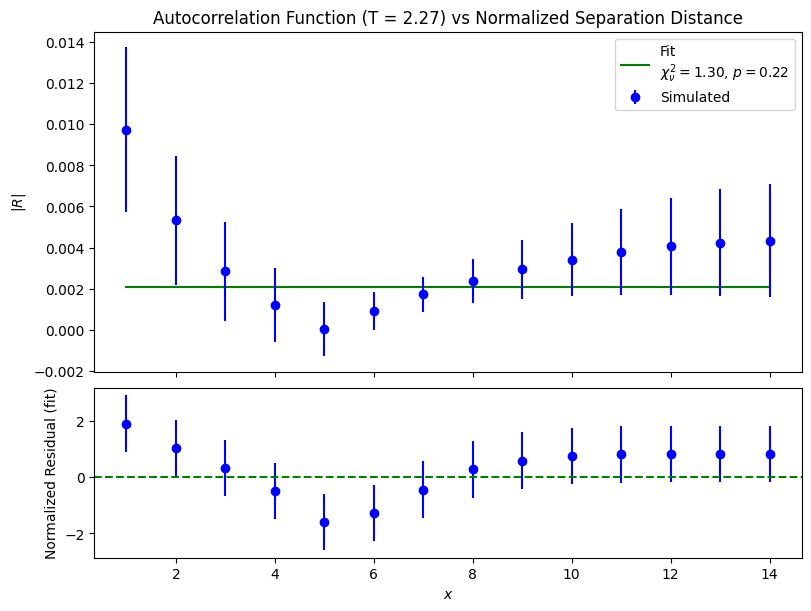

R_typical: 0.0033540927687732845
R_typical: 0.0026188494573127856
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 693473.93
eta = 0.00 ± 0.54
d_c = 14.00 ± 11.04
xi = 8.18 ± 349189257.75
Expected critical exponent: 0.25
Covariance matrix:
[[ 4.80906098e+11  1.45499391e+05 -1.18219757e+06 -2.42153648e+14]
 [ 1.45499391e+05  2.90683253e-01  1.17998423e+00 -7.32642162e+07]
 [-1.18219757e+06  1.17998423e+00  1.21828594e+02  5.95279380e+08]
 [-2.42153648e+14 -7.32642162e+07  5.95279380e+08  1.21933138e+17]]
Reduced chi squared: 0.84
Probability to exceed: 0.59


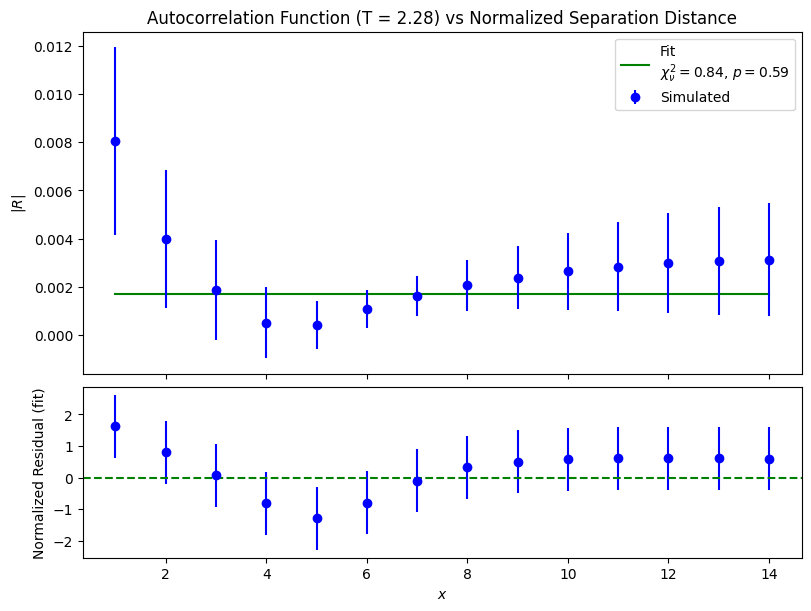

R_typical: 0.0026188494573127856
R_typical: 0.0026896996112082783
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 1311040.61
eta = 0.00 ± 0.48
d_c = 14.00 ± 10.31
xi = 8.62 ± 722980022.37
Expected critical exponent: 0.25
Covariance matrix:
[[ 1.71882749e+12 -2.76695013e+05  4.21068627e+05 -9.47856172e+14]
 [-2.76695013e+05  2.30428528e-01  1.15473711e+00  1.52584874e+08]
 [ 4.21068627e+05  1.15473711e+00  1.06375602e+02 -2.32200380e+08]
 [-9.47856172e+14  1.52584874e+08 -2.32200380e+08  5.22700113e+17]]
Reduced chi squared: 1.09
Probability to exceed: 0.37


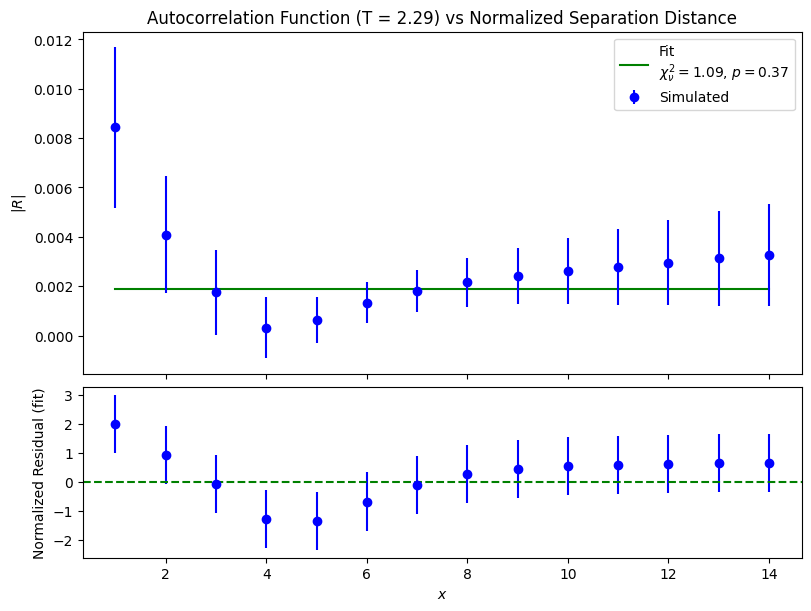

R_typical: 0.0026896996112082783
R_typical: 0.004003128231506578
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 0.50 ± 0.64
d_c = 5.00 ± 25.32
xi = 14.00 ± 22.96
Expected critical exponent: 0.25
Covariance matrix:
[[ 1.74761457e-05 -2.39168224e-11 -5.30056037e-02 -9.21763876e-02]
 [-2.39168223e-11  4.14918084e-01 -1.12749311e+01  1.45902615e-07]
 [-5.30056037e-02 -1.12749311e+01  6.41286476e+02  2.43054978e+02]
 [-9.21763876e-02  1.45902616e-07  2.43054978e+02  5.27185152e+02]]
Reduced chi squared: 2.45
Probability to exceed: 0.01


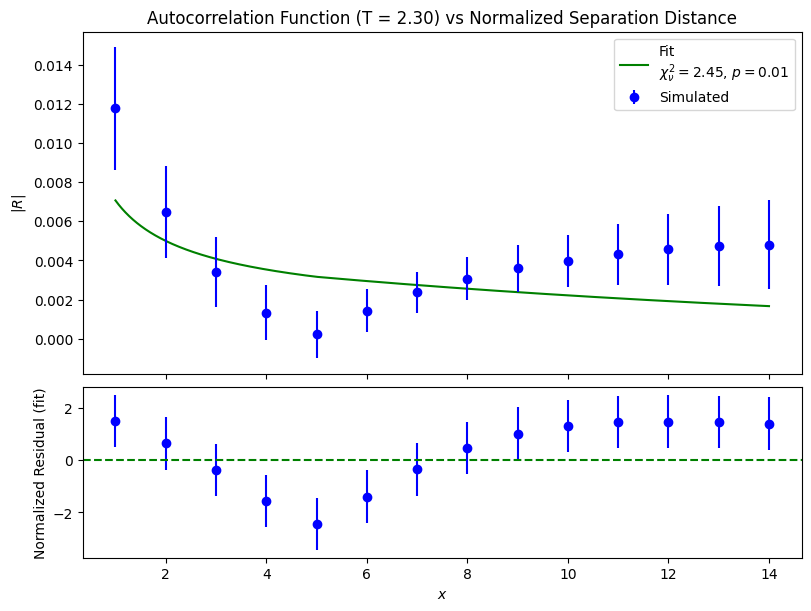

R_typical: 0.004003128231506578
R_typical: 0.0025881693037426642
Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.01 ± 834171.27
eta = 0.00 ± 0.42
d_c = 14.00 ± 9.40
xi = 7.90 ± 333679972.64
Expected critical exponent: 0.25
Covariance matrix:
[[ 6.95841714e+11  5.54718206e+04 -2.26551840e+06 -2.78346248e+14]
 [ 5.54718206e+04  1.73522557e-01  8.27923634e-01 -2.21894905e+07]
 [-2.26551840e+06  8.27923634e-01  8.83892727e+01  9.06238533e+08]
 [-2.78346248e+14 -2.21894905e+07  9.06238533e+08  1.11342324e+17]]
Reduced chi squared: 1.01
Probability to exceed: 0.44


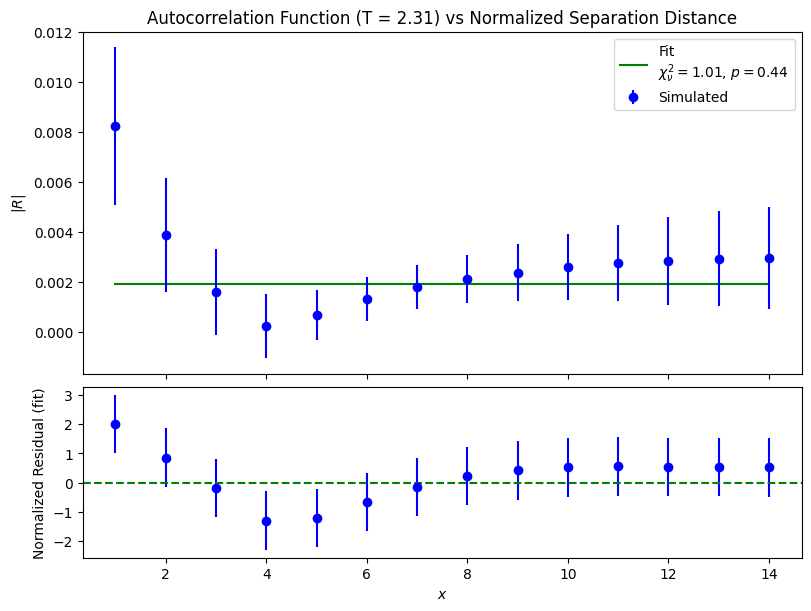

R_typical: 0.0025881693037426642
R_typical: 0.41947385309825097


ValueError: Each lower bound must be strictly less than each upper bound.

In [ ]:
T_filt, xi_mean, xi_std = get_xi_vs_T(T, R_mean_matrix, R_std_matrix, T_range = 0.05, plot_d_scan=True) #Only consider T values close to T_c
create_T_plot(mean=xi_mean, std=xi_std, symbol=r'\xi', name='Correlation Length', log_plot = False, expected_crit_exp=0.0, fitting_model=power_law_exp_decay_fit, T_filt=T_filt) #zeros_like forces std to default which is then propagated for ln

# Multiple CSV Calculations and Plotting

## Pandas to Numpy

In [ ]:
T_xi_range = 0.1 #Only consider T values close to T_c

#All files in directory
E_means = []
E_stds = []
M_means = []
M_stds = []
R_means = []
R_stds = []
cVs = []
chis = []
T_xi = None
xi_means = []
xi_stds = []

for (data,corr) in zip(datas,corrs):
    T, E_mean, E_std, M_mean, M_std= data.T.to_numpy()
    corr_data = corr.T.to_numpy()
    T_corr = corr_data[0]
    assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
    R_data = corr_data[1:]
    R_mean, R_std = np.array([R_data[i] for i in range(0,len(R_data),2)]), np.array([R_data[i] for i in range(1,len(R_data),2)])
    cV = np.square(E_std)/np.square(T) #In units where k_B = 1
    chi = np.square(M_std)/T #In units where k_B = 1
    T_xi, xi_mean, xi_std = get_xi_vs_T(T,R_mean, R_std, T_range = T_xi_range) #Only consider T values close to T_c
    E_means.append(E_mean)
    E_stds.append(E_std)
    M_means.append(M_mean)
    M_stds.append(M_std)
    R_means.append(R_mean)
    R_stds.append(R_std)
    cVs.append(cV)
    chis.append(chi)
    xi_means.append(xi_mean)
    xi_stds.append(xi_std)

E_weights = np.array(E_stds)**-2
E_est = np.average(E_means, axis=0, weights=E_weights)
E_est_std = 1/np.sqrt(np.sum(E_weights,axis=0))
M_weights = np.array(M_stds)**-2
M_est = np.average(M_means, axis=0, weights=M_weights)
M_est_std = 1/np.sqrt(np.sum(M_weights,axis=0))
M_abs_est = np.average(np.abs(M_means), axis=0, weights=M_weights)

xi_weights = np.array(xi_stds)**-2
xi_est = np.average(xi_means, axis=0, weights=xi_weights)
xi_est_std = 1/np.sqrt(np.sum(xi_weights,axis=0))
xi_abs_est = np.average(np.abs(xi_means), axis=0, weights=xi_weights)
xi_abs_est_std = xi_est_std


R_weights = np.array(R_stds)**-2
R_est = np.average(R_means, axis=0, weights=R_weights)
R_est_std = 1/np.sqrt(np.sum(R_weights,axis=0))
cV_mean = np.mean(cVs, axis=0)
cV_std = np.std(cVs, axis=0)/np.sqrt(len(cVs)) #Standard error of the mean
chi_mean = np.mean(chis, axis=0)
chi_std = np.std(chis, axis=0)/np.sqrt(len(chis)) #Standard error of the mean

## Plotting

Reduced chi squared (analytic): 15.327917354757709


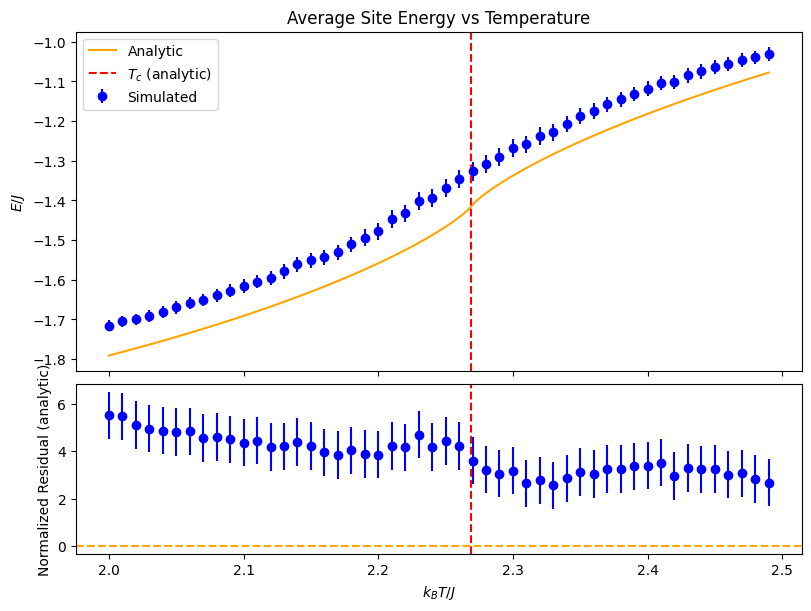

In [ ]:
create_T_plot(E_est, E_est_std, 'E/J', 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic, fitting_model=None)

Fitting model: power_law_fit
Fitting parameters:
k = 1.20 ± 0.01
T_c = 2.27 ± 0.00
crit_exp = 0.14 ± 0.00
Expected critical exponent: 0.12
Covariance matrix:
[[1.18535248e-04 2.27929117e-05 4.64906408e-05]
 [2.27929117e-05 6.88589931e-06 9.74196357e-06]
 [4.64906408e-05 9.74196357e-06 1.86119544e-05]]
Reduced chi squared: 0.11
Probability to exceed: 1.00
Reduced chi squared (analytic): 23.24351218949911


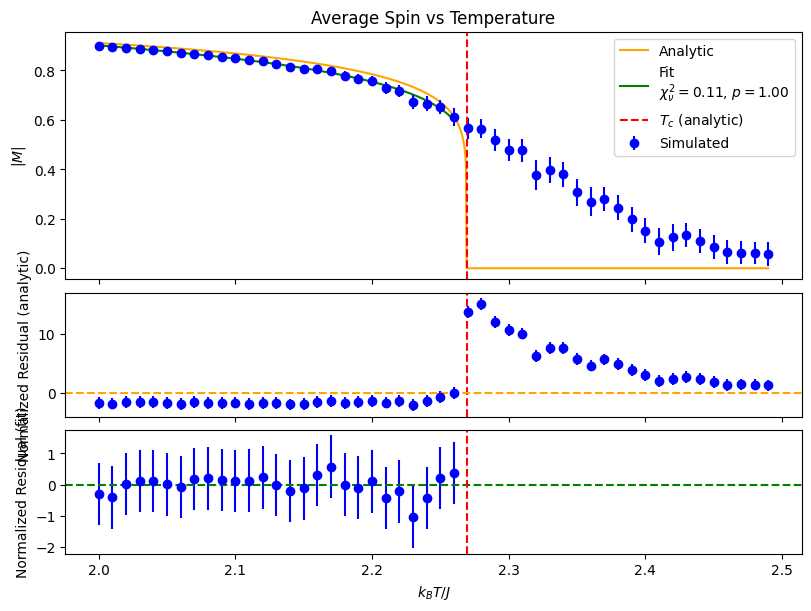

In [ ]:
create_T_plot(np.abs(M_abs_est), M_est_std, '|M|', 'Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, from_above=False)

Fitting model: M_abs_analytic_fit
Fitting parameters:
T_c = 2.25 ± 0.01
Expected critical exponent: 0.12
Covariance matrix:
[[0.00014599]]
Reduced chi squared: 30.98
Probability to exceed: 0.00
Reduced chi squared (analytic): 23.24351218949911


C:\Users\17757\AppData\Local\Temp\ipykernel_47756\1983812828.py:4: RuntimeWarning: invalid value encountered in log10
  result = np.where(result > 0, np.log10(result), order) #Avoid log(0)


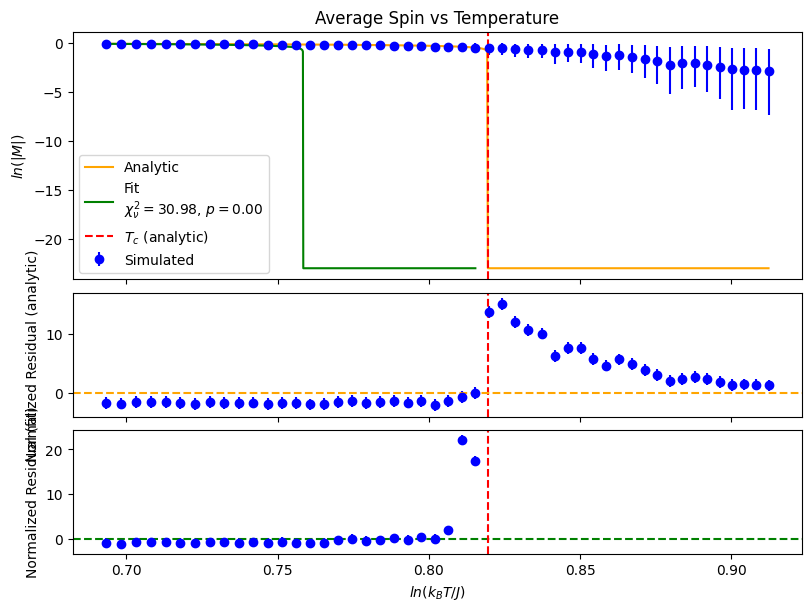

In [ ]:
create_T_plot(np.abs(M_abs_est), M_est_std, '|M|', 'Average Spin', log_plot=True, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, from_above=False, fitting_model=M_abs_analytic_fit)

Fitting model: power_law_fit_neg
Fitting parameters:
k = 0.00 ± 0.00
T_c = 2.01 ± 0.00
crit_exp = 0.00 ± 0.37
Expected critical exponent: 0.00
Covariance matrix:
[[ 4.49800589e-07  0.00000000e+00 -2.48892171e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.48892171e-04  0.00000000e+00  1.38831603e-01]]
Reduced chi squared: 56.82
Probability to exceed: 0.00


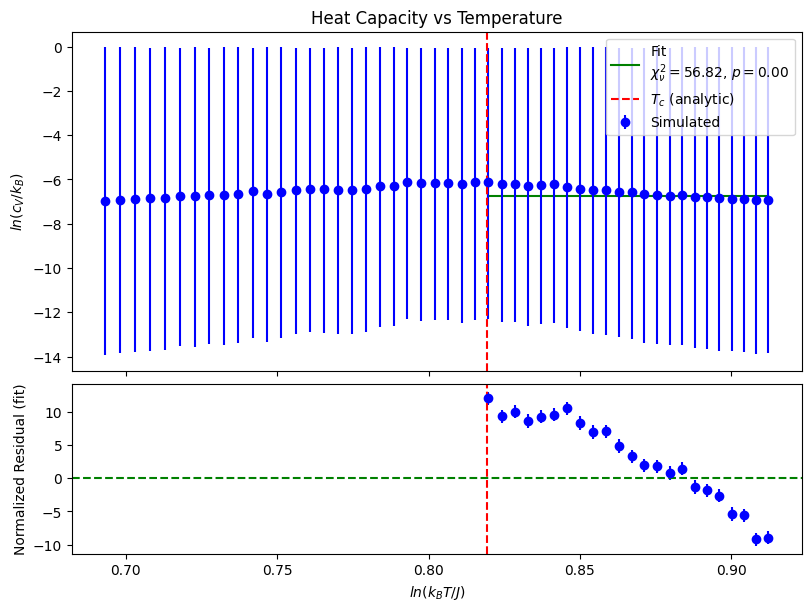

In [ ]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = True, expected_crit_exp=0.0, fitting_model=power_law_fit_neg)
#create_T_plot(cV_mean, cV_std+0.0005, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = True, expected_crit_exp=0.0, get_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

Fitting model: power_law_fit_neg
Fitting parameters:
k = 0.03 ± 0.03
T_c = 3.00 ± 0.00
crit_exp = 0.00 ± 0.58
Expected critical exponent: 1.75
Covariance matrix:
[[ 0.00064016  0.         -0.01471763]
 [ 0.          0.          0.        ]
 [-0.01471763  0.          0.33991735]]
Reduced chi squared: 0.39
Probability to exceed: 0.99


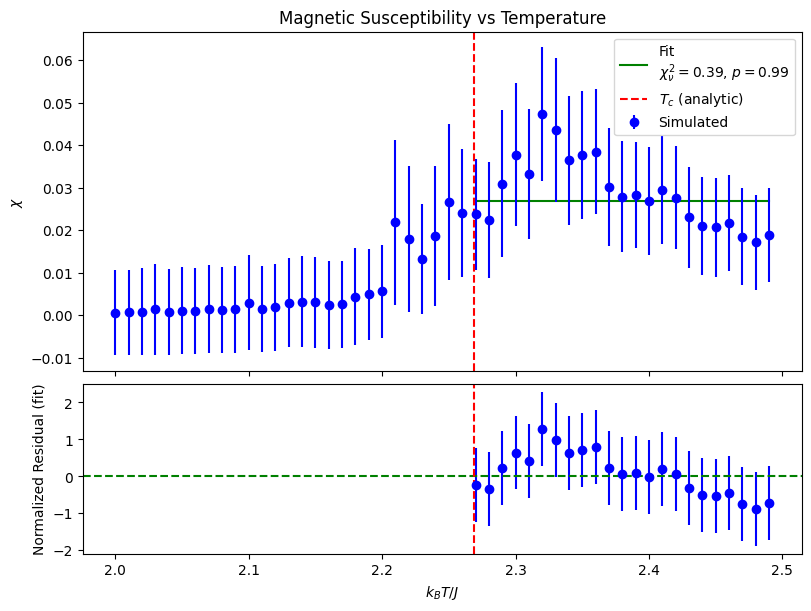

In [ ]:
create_T_plot(chi_mean, chi_std+0.01, symbol= r'\chi', name='Magnetic Susceptibility', log_plot = False, fitting_model=power_law_fit_neg, expected_crit_exp=7/4) #zeros_like forces std to default which is then propagated for ln

Fitting model: power_law_fit
Fitting parameters:
k = 0.05 ± 0.08
T_c = 3.00 ± 0.54
crit_exp = 2.24 ± 2.02
Expected critical exponent: 0.00
Covariance matrix:
[[0.00641041 0.04301315 0.16191187]
 [0.04301315 0.29125566 1.09144657]
 [0.16191187 1.09144657 4.09915031]]
Reduced chi squared: 2.42
Probability to exceed: 0.00


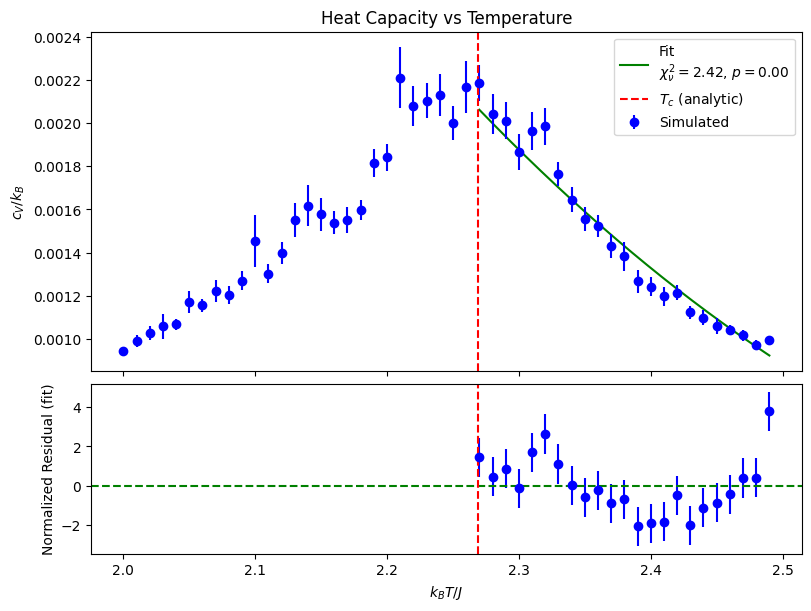

In [ ]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

Fitting model: power_law_fit
Fitting parameters:
k = 0.50 ± 0.15
T_c = 3.00 ± 0.00
crit_exp = 0.00 ± 0.21
Expected critical exponent: 1.00
Covariance matrix:
[[0.02380322 0.         0.03201771]
 [0.         0.         0.        ]
 [0.03201771 0.         0.04310338]]
Reduced chi squared: 0.00
Probability to exceed: 1.00


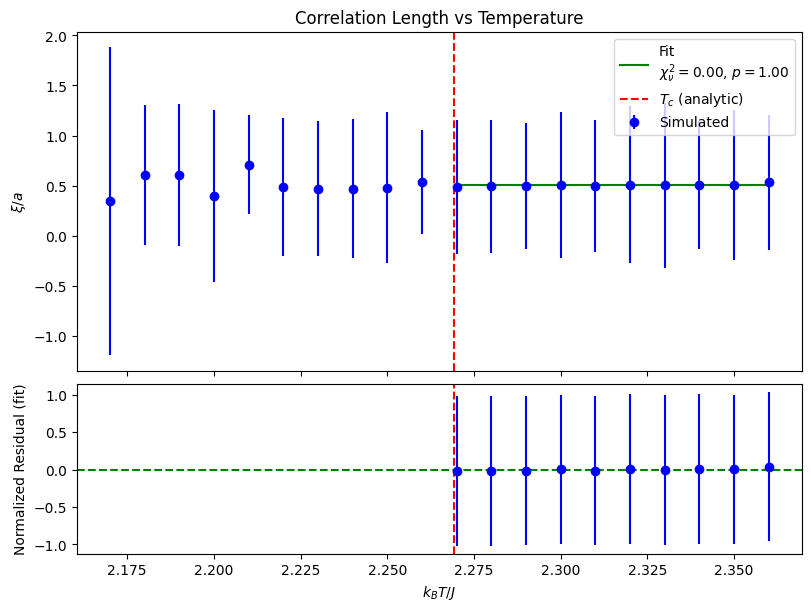

In [ ]:
create_T_plot(xi_abs_est, xi_abs_est_std, r'\xi/a', 'Correlation Length', log_plot = False, fitting_model=power_law_fit, T_filt=T_xi)

## Analysis of Burn-In Time and Annealing
 n_transfer = 3000, inp['n_analyze']  = 5000, inp['n_burnin']   =  [0,100,200,300,400,500,600,700,10000]

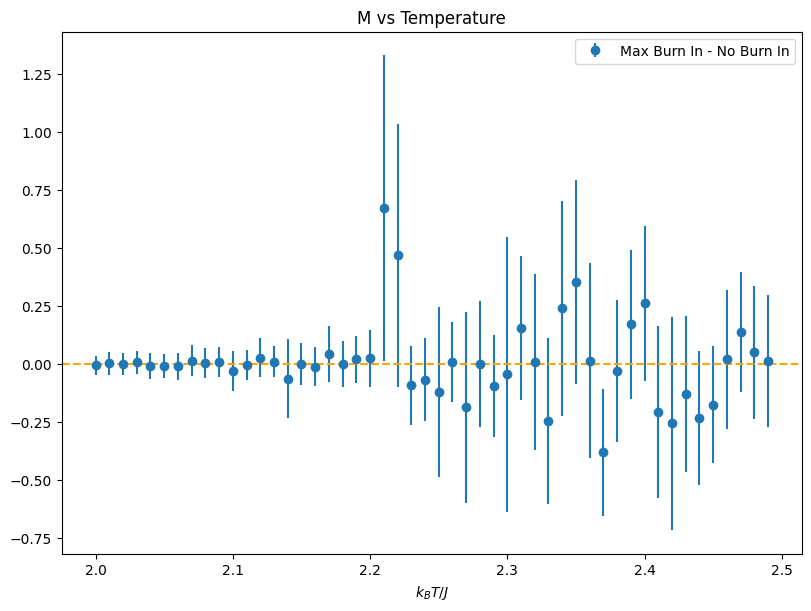

In [ ]:
fig, ax = plt.subplots(1,1, constrained_layout=True, sharex=True)
X_mean_first = np.abs(M_means[0])
X_std_first = M_stds[0]
X_mean_last = np.abs(M_means[-1])
X_std_last = M_stds[-1]
X_mean_diff = X_mean_last - X_mean_first
X_std_diff = np.sqrt(X_std_last**2 + X_std_first**2) #Assuming independent errors
ax.errorbar(x=T, y=X_mean_diff, yerr=X_std_diff, fmt='o', label='Max Burn In - No Burn In')
ax.axhline(0, color='orange', linestyle='--')
ax.set_xlabel('$k_BT / J$')
'''
res_ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')      
ax.plot(using[1], using[5], color='orange', label='Analytic')               
res_ax.set_xlabel(T_label)
res_ax.set_ylabel('Normalized Residual')
res_ax.axhline(0, color='orange', linestyle='--')      
else: #Plotting specific to not having residuals
    fig, ax = plt.subplots(1,1, constrained_layout=True)
    ax.set_xlabel(T_label)
#Plotting common to all variants    
if with_errorbar:
    ax.errorbar(using[0], using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    else:        
    ax.errorbar(using[0], using[3], fmt='o', yerr=None, color='blue', label='Simulated')
ax.set_ylabel(X_label)
ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')    
'''
ax.legend()
ax.set_title('M vs Temperature')
plt.show()